In [1]:
import numpy as np
import pandas as pd
from dateutil import parser
from datetime import datetime, timedelta
from collections import OrderedDict

import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score

In [2]:
config = OrderedDict([
    ('10/09/2012', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'MER', 'ICT', 'JFC', 'JGS', 'BEL', 'MBT', 'MEG', 'MWC', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'SMDC', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('11/03/2013', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'MER', 'ICT', 'JFC', 'JGS', 'BEL', 'MBT', 'MEG', 'MWC', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('09/16/2013', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MWC', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('03/17/2014', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('09/15/2014', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'EMP', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('12/09/2015', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'EMP', 'RLC', 'EDC', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('03/13/2017', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PGOLD', 'RLC', 'EDC', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('09/28/2017', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PGOLD', 'RLC', 'RRHI', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('02/18/2019', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'BLOOM', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PGOLD', 'RLC', 'RRHI', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
])

In [3]:
days_ago = 0
def get_n_days_tweets(date, n):
    end_date = get_previous_day(date)
    start_date = end_date - timedelta(days=n)
    return pd.date_range(start_date, end_date).strftime('%m/%d/%Y').values

def get_previous_day(date):
    return datetime.strptime(date, '%m/%d/%Y') - timedelta(days=1)

def format_date(date, format='%m/%d/%Y'):
    return date.strftime(format)

def get_member_stocks(date):
    parsed_date = get_previous_day(date)
    for change_date, member_stocks in config.items():
        parsed_change_date = datetime.strptime(change_date, '%m/%d/%Y')
        if parsed_date >= parsed_change_date:
            return member_stocks

def get_relevant_tweets(date):
#     return tweets_df[(tweets_df['date'] == format_date(get_previous_day(date))) & (tweets_df['symbol'].isin(get_member_stocks(date)))]
#     return tweets_df[(tweets_df['date'] == format_date(get_previous_day(date))) & (tweets_df['symbol'] == 'SMC')]
    return tweets_df[(tweets_df['date'].isin(get_n_days_tweets(date, days_ago))) & (tweets_df['symbol'].isin(get_member_stocks(date)))]

In [4]:
get_n_days_tweets('02/02/2020', 0)

array(['02/01/2020'], dtype=object)

In [5]:
# company = 'SMC'
company = 'PSEI'
quotes_file = 'consolidated_{}_quotes.csv'.format(company.lower())
main_df = pd.read_csv(quotes_file, usecols=lambda x: 'Unnamed' not in x)[2:]
tweets_df = pd.read_csv('combined_tweets_with_sentiment_scores.csv', index_col=0)
main_df

c:\users\lex\docume~1\ftwsch~1\env\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,symbol,date,open,high,low,close,volume,nfbs,previous_close
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22
...,...,...,...,...,...,...,...,...,...
1754,^PSEi,01/20/2020,7727.45,7727.45,7513.95,7552.60,6274859,-512900,7722.58
1755,^PSEi,01/21/2020,7570.20,7586.59,7442.13,7466.65,7760479,422451,7552.60
1756,^PSEi,01/22/2020,7469.14,7478.10,7425.86,7468.73,7101276,-874576,7466.65
1757,^PSEi,01/23/2020,7503.64,7616.35,7495.60,7616.35,6628711,-132599,7468.73


In [6]:
import re
illegal_strings = 'Media General|Alamos Gold|Mobile Telesystems|Manitoba Telecom Services|Mobil\'nye|TeleSistemy|Russia|SM Energy|SMEnergy|Praxair|Pelangio|Michael Page International|Maurel et Prom|FibroGen|Direxion Emerging Markets|Direxion|Emerging Market|Claim Free|Accor|French|Bridgepoint Education|Zovio|Belmond|ASX|DTG'
tweets_df = tweets_df[~tweets_df['tweet'].str.contains(illegal_strings, flags=re.I, na=False)]
tweets_df

,symbol,epoch_time,name,handle,url,tweet,reply_count,retweet_count,favorite_count,date,sentiment_score,label
0,AC,1192399907,D,davvyk,https://twitter.com/davvyk/status/335801692,hope england flatten the $ac)sts in RWC,0,0,0,10/15/2007,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",1
1,AC,1218207877,JKIngram84,JKIngram154,https://twitter.com/JKIngram154/status/881583626,I´ve been fighting with banks for the last 12 ...,0,0,0,08/09/2008,"{'neg': 0.095, 'neu': 0.53, 'pos': 0.375, 'com...",1
2,AC,1261780693,"DIRECTED BY\r\nAC,🎥",mikemikefilms,https://twitter.com/mikemikefilms/status/70438...,& we STILL gotta hit up $ac!.. Hmm I wonder if...,0,0,0,12/26/2009,"{'neg': 0.136, 'neu': 0.767, 'pos': 0.098, 'co...",-1
3,AC,1261298199,BABY D,DEONNAROCKSTARR,https://twitter.com/DEONNAROCKSTARR/status/685...,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,0,0,0,12/20/2009,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",1
13,AC,1259889821,JENNIFER WILLIAM$,scarygirl916,https://twitter.com/scarygirl916/status/632215...,@fionuhh so I thot I was gonna die cuz therezz...,0,0,0,12/04/2009,"{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...",-1
...,...,...,...,...,...,...,...,...,...,...,...,...
206243,URC,1505790466,MyTradePH-Abacus Sec,MyTradePH,https://twitter.com/MyTradePH/status/909977286...,"... $URC, $SMC, $BEL. Read the full report at ...",0,0,0,09/19/2017,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
206244,URC,1505737174,kentir,ko_kom101,https://twitter.com/ko_kom101/status/909753762...,"coindera: Top 3\r\nURC,\r\nURC, $URC $BTC on Y...",0,0,1,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1
206245,URC,1505736062,Shitcoin Calls,ShitcoinCalls,https://twitter.com/ShitcoinCalls/status/90974...,"New post in Shitcoin Calls: Top 3\r\nURC, $URC...",0,0,2,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1
206246,URC,1505736031,Coindera,coindera,https://twitter.com/coindera/status/9097489714...,"Top 3\r\nURC,\r\nURC, $URC $BTC on @YobitExcha...",0,0,2,09/18/2017,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",1


In [7]:
# because the dates aren't zero padded :/
main_df['date'] = main_df['date'].apply(lambda x: parser.parse(x).strftime('%m/%d/%Y'))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22
...,...,...,...,...,...,...,...,...,...
1754,^PSEi,01/20/2020,7727.45,7727.45,7513.95,7552.60,6274859,-512900,7722.58
1755,^PSEi,01/21/2020,7570.20,7586.59,7442.13,7466.65,7760479,422451,7552.60
1756,^PSEi,01/22/2020,7469.14,7478.10,7425.86,7468.73,7101276,-874576,7466.65
1757,^PSEi,01/23/2020,7503.64,7616.35,7495.60,7616.35,6628711,-132599,7468.73


In [8]:
main_df['log_return'] = np.log(main_df['close'] / main_df['previous_close'])
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101
...,...,...,...,...,...,...,...,...,...,...
1754,^PSEi,01/20/2020,7727.45,7727.45,7513.95,7552.60,6274859,-512900,7722.58,-0.022257
1755,^PSEi,01/21/2020,7570.20,7586.59,7442.13,7466.65,7760479,422451,7552.60,-0.011445
1756,^PSEi,01/22/2020,7469.14,7478.10,7425.86,7468.73,7101276,-874576,7466.65,0.000279
1757,^PSEi,01/23/2020,7503.64,7616.35,7495.60,7616.35,6628711,-132599,7468.73,0.019572


In [9]:
# because 1500 turns to 1.5K :/
tweets_df['favorite_count'] = tweets_df['favorite_count'].apply(
    lambda x: float(x) if 'K' not in str(x) else float(str(x).strip('K')) * 1000)
tweets_df

,symbol,epoch_time,name,handle,url,tweet,reply_count,retweet_count,favorite_count,date,sentiment_score,label
0,AC,1192399907,D,davvyk,https://twitter.com/davvyk/status/335801692,hope england flatten the $ac)sts in RWC,0,0,0.0,10/15/2007,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",1
1,AC,1218207877,JKIngram84,JKIngram154,https://twitter.com/JKIngram154/status/881583626,I´ve been fighting with banks for the last 12 ...,0,0,0.0,08/09/2008,"{'neg': 0.095, 'neu': 0.53, 'pos': 0.375, 'com...",1
2,AC,1261780693,"DIRECTED BY\r\nAC,🎥",mikemikefilms,https://twitter.com/mikemikefilms/status/70438...,& we STILL gotta hit up $ac!.. Hmm I wonder if...,0,0,0.0,12/26/2009,"{'neg': 0.136, 'neu': 0.767, 'pos': 0.098, 'co...",-1
3,AC,1261298199,BABY D,DEONNAROCKSTARR,https://twitter.com/DEONNAROCKSTARR/status/685...,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,0,0,0.0,12/20/2009,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",1
13,AC,1259889821,JENNIFER WILLIAM$,scarygirl916,https://twitter.com/scarygirl916/status/632215...,@fionuhh so I thot I was gonna die cuz therezz...,0,0,0.0,12/04/2009,"{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...",-1
...,...,...,...,...,...,...,...,...,...,...,...,...
206243,URC,1505790466,MyTradePH-Abacus Sec,MyTradePH,https://twitter.com/MyTradePH/status/909977286...,"... $URC, $SMC, $BEL. Read the full report at ...",0,0,0.0,09/19/2017,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
206244,URC,1505737174,kentir,ko_kom101,https://twitter.com/ko_kom101/status/909753762...,"coindera: Top 3\r\nURC,\r\nURC, $URC $BTC on Y...",0,0,1.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1
206245,URC,1505736062,Shitcoin Calls,ShitcoinCalls,https://twitter.com/ShitcoinCalls/status/90974...,"New post in Shitcoin Calls: Top 3\r\nURC, $URC...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1
206246,URC,1505736031,Coindera,coindera,https://twitter.com/coindera/status/9097489714...,"Top 3\r\nURC,\r\nURC, $URC $BTC on @YobitExcha...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",1


In [10]:
main_df['tweet_count'] = main_df['date'].apply(lambda date: len(get_relevant_tweets(date).index))

In [11]:
main_df.head()

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,11
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,7
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,18
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,15
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,9


In [12]:
# main_df['favorite_boost_score'] = main_df['date'].apply(lambda x: tweets_df[tweets_df['date'] == x])
# date = main_df.iloc[0].date
# tweet_subset = tweets_df[tweets_df['date'] == date]
# print(len(tweet_subset[tweet_subset['label'] == 1].index))
# print(tweet_subset['label']*(abs(tweet_subset['label']) + (0.5*tweet_subset['favorite_count'])))

In [13]:
# get_member_stocks(date)
# stcks = ['SMC']
main_df['positive_tweets_count'] = main_df['date'].apply(
    lambda date: len(tweets_df[(tweets_df['date'].isin(get_n_days_tweets(date, days_ago))) & (tweets_df['label'] == 1) & (tweets_df['symbol'].isin(get_member_stocks(date)))].index))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,11,10
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,7,7
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,18,17
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,15,15
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...
1754,^PSEi,01/20/2020,7727.45,7727.45,7513.95,7552.60,6274859,-512900,7722.58,-0.022257,0,0
1755,^PSEi,01/21/2020,7570.20,7586.59,7442.13,7466.65,7760479,422451,7552.60,-0.011445,0,0
1756,^PSEi,01/22/2020,7469.14,7478.10,7425.86,7468.73,7101276,-874576,7466.65,0.000279,0,0
1757,^PSEi,01/23/2020,7503.64,7616.35,7495.60,7616.35,6628711,-132599,7468.73,0.019572,0,0


In [14]:
main_df['positive_tweets_ratio'] =  (main_df['positive_tweets_count'] / main_df['tweet_count']).fillna(0)
main_df
# main_df[main_df.isnull().any(axis=1)]

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,11,10,0.909091
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,7,7,1.000000
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,18,17,0.944444
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,15,15,1.000000
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,9,9,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,^PSEi,01/20/2020,7727.45,7727.45,7513.95,7552.60,6274859,-512900,7722.58,-0.022257,0,0,0.000000
1755,^PSEi,01/21/2020,7570.20,7586.59,7442.13,7466.65,7760479,422451,7552.60,-0.011445,0,0,0.000000
1756,^PSEi,01/22/2020,7469.14,7478.10,7425.86,7468.73,7101276,-874576,7466.65,0.000279,0,0,0.000000
1757,^PSEi,01/23/2020,7503.64,7616.35,7495.60,7616.35,6628711,-132599,7468.73,0.019572,0,0,0.000000


In [15]:
tweets_df['boosted_score'] = tweets_df.apply(
    lambda x: x['label'] * (abs(x['label']) + (0.5 * int(x['favorite_count']))), axis=1)
tweets_df

,symbol,epoch_time,name,handle,url,tweet,reply_count,retweet_count,favorite_count,date,sentiment_score,label,boosted_score
0,AC,1192399907,D,davvyk,https://twitter.com/davvyk/status/335801692,hope england flatten the $ac)sts in RWC,0,0,0.0,10/15/2007,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",1,1.0
1,AC,1218207877,JKIngram84,JKIngram154,https://twitter.com/JKIngram154/status/881583626,I´ve been fighting with banks for the last 12 ...,0,0,0.0,08/09/2008,"{'neg': 0.095, 'neu': 0.53, 'pos': 0.375, 'com...",1,1.0
2,AC,1261780693,"DIRECTED BY\r\nAC,🎥",mikemikefilms,https://twitter.com/mikemikefilms/status/70438...,& we STILL gotta hit up $ac!.. Hmm I wonder if...,0,0,0.0,12/26/2009,"{'neg': 0.136, 'neu': 0.767, 'pos': 0.098, 'co...",-1,-1.0
3,AC,1261298199,BABY D,DEONNAROCKSTARR,https://twitter.com/DEONNAROCKSTARR/status/685...,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,0,0,0.0,12/20/2009,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",1,1.0
13,AC,1259889821,JENNIFER WILLIAM$,scarygirl916,https://twitter.com/scarygirl916/status/632215...,@fionuhh so I thot I was gonna die cuz therezz...,0,0,0.0,12/04/2009,"{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...",-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206243,URC,1505790466,MyTradePH-Abacus Sec,MyTradePH,https://twitter.com/MyTradePH/status/909977286...,"... $URC, $SMC, $BEL. Read the full report at ...",0,0,0.0,09/19/2017,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0
206244,URC,1505737174,kentir,ko_kom101,https://twitter.com/ko_kom101/status/909753762...,"coindera: Top 3\r\nURC,\r\nURC, $URC $BTC on Y...",0,0,1.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,1.5
206245,URC,1505736062,Shitcoin Calls,ShitcoinCalls,https://twitter.com/ShitcoinCalls/status/90974...,"New post in Shitcoin Calls: Top 3\r\nURC, $URC...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,2.0
206246,URC,1505736031,Coindera,coindera,https://twitter.com/coindera/status/9097489714...,"Top 3\r\nURC,\r\nURC, $URC $BTC on @YobitExcha...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",1,2.0


In [16]:
main_df['favorite_boosted_score'] = main_df['date'].apply(lambda date: sum((get_relevant_tweets(date))['boosted_score']))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,11,10,0.909091,9.5
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,7,7,1.000000,8.0
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,18,17,0.944444,18.5
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,15,15,1.000000,15.0
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,9,9,1.000000,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,^PSEi,01/20/2020,7727.45,7727.45,7513.95,7552.60,6274859,-512900,7722.58,-0.022257,0,0,0.000000,0.0
1755,^PSEi,01/21/2020,7570.20,7586.59,7442.13,7466.65,7760479,422451,7552.60,-0.011445,0,0,0.000000,0.0
1756,^PSEi,01/22/2020,7469.14,7478.10,7425.86,7468.73,7101276,-874576,7466.65,0.000279,0,0,0.000000,0.0
1757,^PSEi,01/23/2020,7503.64,7616.35,7495.60,7616.35,6628711,-132599,7468.73,0.019572,0,0,0.000000,0.0


In [17]:
main_df['hype_score'] = main_df['date'].apply(
    lambda date: sum(abs((get_relevant_tweets(date))['boosted_score'])))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,11,10,0.909091,9.5,11.5
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,7,7,1.000000,8.0,8.0
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,18,17,0.944444,18.5,20.5
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,15,15,1.000000,15.0,15.0
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,9,9,1.000000,9.5,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,^PSEi,01/20/2020,7727.45,7727.45,7513.95,7552.60,6274859,-512900,7722.58,-0.022257,0,0,0.000000,0.0,0.0
1755,^PSEi,01/21/2020,7570.20,7586.59,7442.13,7466.65,7760479,422451,7552.60,-0.011445,0,0,0.000000,0.0,0.0
1756,^PSEi,01/22/2020,7469.14,7478.10,7425.86,7468.73,7101276,-874576,7466.65,0.000279,0,0,0.000000,0.0,0.0
1757,^PSEi,01/23/2020,7503.64,7616.35,7495.60,7616.35,6628711,-132599,7468.73,0.019572,0,0,0.000000,0.0,0.0


In [18]:
main_df['target'] = main_df.apply(lambda x: int(x['close'] > x['previous_close']), axis=1)
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,11,10,0.909091,9.5,11.5,0
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,7,7,1.000000,8.0,8.0,0
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,18,17,0.944444,18.5,20.5,1
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,15,15,1.000000,15.0,15.0,1
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,9,9,1.000000,9.5,9.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,^PSEi,01/20/2020,7727.45,7727.45,7513.95,7552.60,6274859,-512900,7722.58,-0.022257,0,0,0.000000,0.0,0.0,0
1755,^PSEi,01/21/2020,7570.20,7586.59,7442.13,7466.65,7760479,422451,7552.60,-0.011445,0,0,0.000000,0.0,0.0,0
1756,^PSEi,01/22/2020,7469.14,7478.10,7425.86,7468.73,7101276,-874576,7466.65,0.000279,0,0,0.000000,0.0,0.0,1
1757,^PSEi,01/23/2020,7503.64,7616.35,7495.60,7616.35,6628711,-132599,7468.73,0.019572,0,0,0.000000,0.0,0.0,1


In [19]:
main_df.to_csv('out.csv')

In [20]:
main_df.describe()

,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
count,1757.000000,1757.000000,1757.000000,1757.000000,1.757000e+03,1.757000e+03,1756.000000,1756.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000
mean,7305.215948,7342.247291,7261.730672,7304.290046,2.113681e+07,1.707499e+06,7303.870478,0.000186,52.385316,47.417188,0.896684,63.059476,79.649118,0.527604
std,709.074649,709.023182,705.252938,708.604712,4.172282e+08,6.137613e+07,709.336252,0.010371,38.824089,35.405455,0.121252,62.902461,80.098762,0.499380
min,5353.710000,5372.680000,5353.470000,5353.470000,6.339340e+05,-2.818710e+07,5353.470000,-0.069885,0.000000,0.000000,0.000000,-5.500000,0.000000,0.000000
25%,6846.550000,6874.630000,6803.390000,6843.830000,5.880245e+06,-5.565070e+05,6843.410000,-0.005576,27.000000,25.000000,0.870968,26.000000,33.500000,0.000000
50%,7358.530000,7390.000000,7320.640000,7357.280000,7.201591e+06,-1.052680e+05,7357.000000,0.000564,47.000000,43.000000,0.916667,48.000000,61.000000,1.000000
75%,7848.450000,7879.660000,7804.980000,7845.490000,8.919241e+06,3.479980e+05,7845.752500,0.006140,70.000000,64.000000,0.958333,83.000000,103.000000,1.000000
max,9051.750000,9078.370000,9008.410000,9058.620000,1.596931e+10,2.528117e+09,9058.620000,0.055419,450.000000,428.000000,1.000000,928.500000,1094.500000,1.000000


In [21]:
# from sklearn.preprocessing import StandardScaler
from tpot import TPOTClassifier

features = ['volume', 'nfbs', 'tweet_count', 'positive_tweets_ratio', 'favorite_boosted_score', 'hype_score']
X = main_df[features][:-249]
# X = StandardScaler().fit_transform(X)
y = main_df['target'][:-249]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# Initialize model
# model = LogisticRegression()
model = xgboost.XGBClassifier(learning_rate=0.01, min_child_weight=8)
# model = TPOTClassifier(generations=10, verbosity=2)

# Fit model
model.fit(X_train, y_train)
# Predict prices for test data
y_predicted = model.predict(X_test)

print('Features used: {}'.format(features))
print('Accuracy: {}'.format(accuracy_score(y_test, y_predicted)))
print('Precision: {}'.format(precision_score(y_test, y_predicted)))
print('Recall: {}'.format(recall_score(y_test, y_predicted)))
print('ROC AUC: {}'.format(roc_auc_score(y_test, y_predicted)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_predicted)))

scores = cross_val_score(model, X, y, cv=5)
# print(scores)
print('CV score: {}'.format(np.average(scores)))

Features used: ['volume', 'nfbs', 'tweet_count', 'positive_tweets_ratio', 'favorite_boosted_score', 'hype_score']
Accuracy: 0.6423841059602649
Precision: 0.650137741046832
Recall: 0.7261538461538461
ROC AUC: 0.6354783567686794
Confusion Matrix:
[[152 127]
 [ 89 236]]
CV score: 0.6200765659721458


In [22]:
# test_data = main_df.iloc[-249:]
# test_data = main_df.iloc[-238:]
# test_data = main_df.iloc[-254:]
test_data = main_df.iloc[-254:-16]
test_data

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
1505,^PSEi,01/02/2019,7496.57,7540.26,7465.76,7489.20,3355990,-4576,7466.02,0.003100,5,5,1.000000,6.5,6.5,1
1506,^PSEi,01/03/2019,7507.48,7680.60,7490.28,7680.60,7164035,196718,7489.20,0.025236,36,29,0.805556,40.0,63.0,1
1507,^PSEi,01/04/2019,7657.18,7801.50,7657.18,7761.11,9042454,1018544,7680.60,0.010428,56,51,0.910714,112.5,123.5,1
1508,^PSEi,01/07/2019,7800.88,7900.70,7787.66,7787.66,8408604,1224724,7761.11,0.003415,18,17,0.944444,22.0,24.0,1
1509,^PSEi,01/08/2019,7820.26,7826.08,7702.12,7702.12,6032433,152328,7787.66,-0.011045,66,63,0.954545,213.5,224.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,254,225,0.885827,437.5,546.5,0
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,199,180,0.904523,563.5,694.5,1
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,73,71,0.972603,366.0,417.0,1
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,52,51,0.980769,74.0,91.0,0


In [23]:
X_test_data = test_data[features]
y_test_data = test_data['target']

y_test_data_predicted = model.predict(X_test_data)
print('2019 Predictions')
print('Features used: {}'.format(features))
print('Accuracy: {}'.format(accuracy_score(y_test_data, y_test_data_predicted)))
print('Precision: {}'.format(precision_score(y_test_data, y_test_data_predicted)))
print('Recall: {}'.format(recall_score(y_test_data, y_test_data_predicted)))
print('ROC AUC: {}'.format(roc_auc_score(y_test_data, y_test_data_predicted)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test_data, y_test_data_predicted)))

2019 Predictions
Features used: ['volume', 'nfbs', 'tweet_count', 'positive_tweets_ratio', 'favorite_boosted_score', 'hype_score']
Accuracy: 0.6176470588235294
Precision: 0.6083916083916084
Recall: 0.7131147540983607
ROC AUC: 0.6151780667043527
Confusion Matrix:
[[60 56]
 [35 87]]


In [24]:
y_test_data.values

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0], dtype=int64)

In [25]:
y_test_data_predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [26]:
test = X_test_data.copy()
test['target'] = y_test_data
test['predicted'] = y_test_data_predicted
test['date'] = test_data['date']
test.to_csv('predicted.csv')

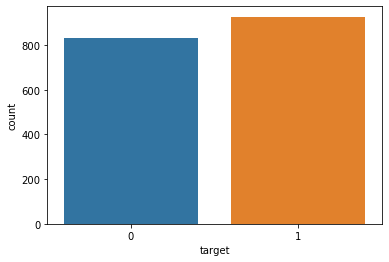

In [27]:
import seaborn as sns
main_df.describe()
sns.countplot(main_df['target'])
# sns.countplot(tweets_df['label'])

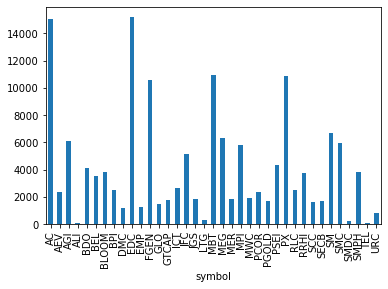

In [28]:
tweets_df.groupby(['symbol']).count()['date'].plot(kind='bar')

In [29]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [30]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

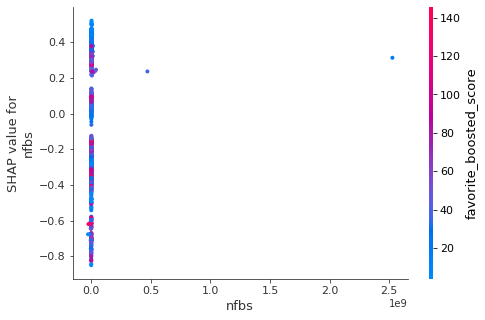

In [31]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("nfbs", shap_values, X)

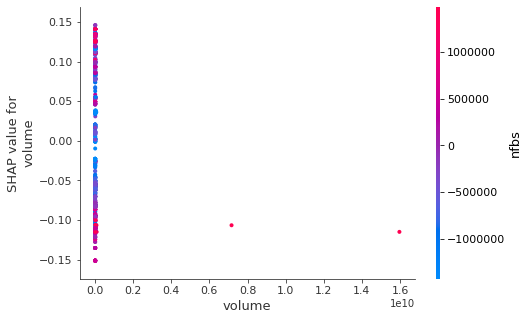

In [32]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("volume", shap_values, X)

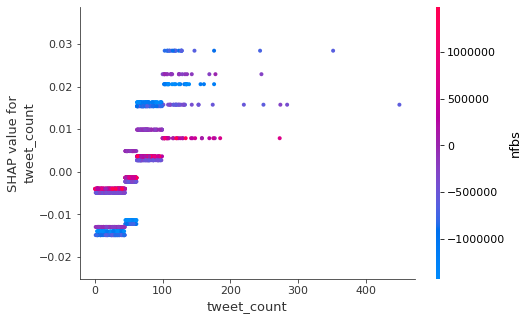

In [33]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("tweet_count", shap_values, X)

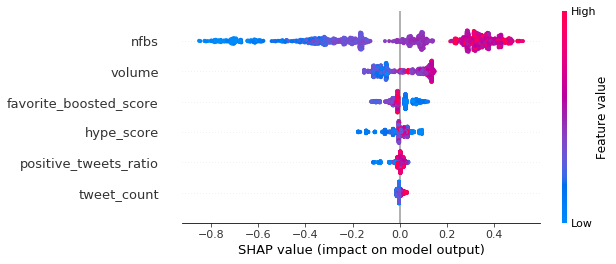

In [34]:
shap.summary_plot(shap_values, X)

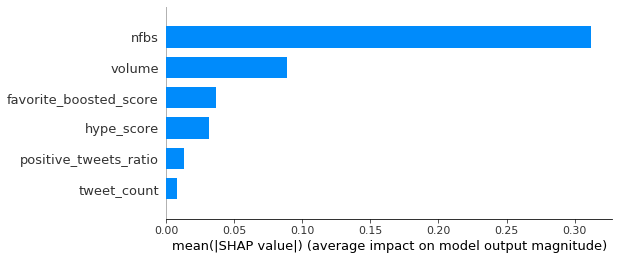

In [35]:
shap.summary_plot(shap_values, X, plot_type="bar")

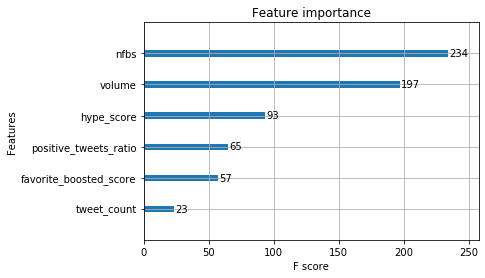

In [36]:
xgboost.plot_importance(model, importance_type='weight')

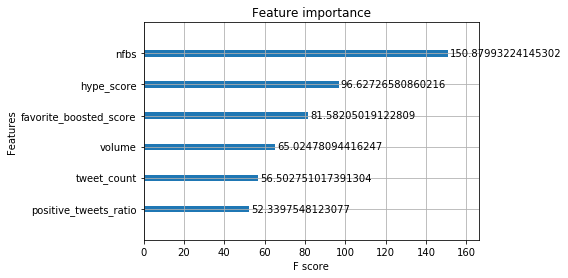

In [37]:
xgboost.plot_importance(model, importance_type='cover')

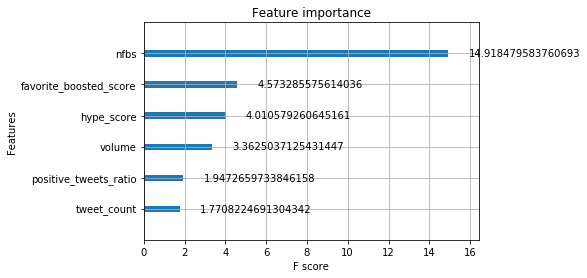

In [38]:
xgboost.plot_importance(model, importance_type='gain')

## Sentiment Analysis

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pattern.en import ngrams, sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Data Preprocessing and Feature Engineering
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [40]:
train_tweets = tweets_df[['tweet', 'label']]
test_tweets = tweets_df[['tweet']]

In [41]:
def text_processing(tweet):
    
    #Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet)
#     print(tweet)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet_list):
        tweet_list = [ele for ele in tweet_list.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
#     print(no_punc_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word, 'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    
    return normalization(no_punc_tweet)

In [42]:
d = train_tweets.copy()
d = d.iloc[:10]
d['tweet_list'] = d['tweet'].apply(text_processing)
d.head()

,tweet,label,tweet_list
0,hope england flatten the $ac)sts in RWC,1,"[hope, england, flatten, ac, sts, RWC]"
1,I´ve been fighting with banks for the last 12 ...,1,"[fight, bank, last, hours, Fun, fun, fun, F, r..."
2,& we STILL gotta hit up $ac!.. Hmm I wonder if...,-1,"[STILL, get, ta, hit, ac, Hmm, wonder, aunt, l..."
3,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,1,"[OK, GUY, IM, READY, LI, TEN, LITTLE, BIT, MU,..."
13,@fionuhh so I thot I was gonna die cuz therezz...,-1,"[fionuhh, thot, gon, na, die, cuz, therezz, sh..."


In [43]:
# train_tweets['tweet_list'] = train_tweets['tweet'].apply(text_processing)
# test_tweets['tweet_list'] = test_tweets['tweet'].apply(text_processing)

X = train_tweets['tweet']
y = train_tweets['label']

In [44]:
# from sklearn.model_selection import train_test_split
# msg_train, msg_test, label_train, label_test = train_test_split(train_tweets['tweet'], train_tweets['label'], test_size=0.2)
# msg_test
# pipeline = Pipeline([
#     ('bow', CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
#     ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
#     ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
# ])
# msg_train.fillna('', inplace=True)
# msg_test.fillna('', inplace=True)
# # msg_train.to_csv('test.csv')

# pipeline.fit(msg_train, label_train)

# predictions = pipeline.predict(msg_test)

# print(classification_report(predictions, label_test))
# print ('\n')
# print(confusion_matrix(predictions, label_test))
# print(accuracy_score(predictions, label_test))

## Exploration

In [45]:
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,11,10,0.909091,9.5,11.5,0
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,7,7,1.000000,8.0,8.0,0
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,18,17,0.944444,18.5,20.5,1
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,15,15,1.000000,15.0,15.0,1
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,9,9,1.000000,9.5,9.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,^PSEi,01/20/2020,7727.45,7727.45,7513.95,7552.60,6274859,-512900,7722.58,-0.022257,0,0,0.000000,0.0,0.0,0
1755,^PSEi,01/21/2020,7570.20,7586.59,7442.13,7466.65,7760479,422451,7552.60,-0.011445,0,0,0.000000,0.0,0.0,0
1756,^PSEi,01/22/2020,7469.14,7478.10,7425.86,7468.73,7101276,-874576,7466.65,0.000279,0,0,0.000000,0.0,0.0,1
1757,^PSEi,01/23/2020,7503.64,7616.35,7495.60,7616.35,6628711,-132599,7468.73,0.019572,0,0,0.000000,0.0,0.0,1


In [46]:
decrease = main_df[main_df['target'] == 0]
increase = main_df[main_df['target'] == 1]

In [47]:
print(decrease['nfbs'].mean())
print(increase['nfbs'].mean())

357041.0626506024
2916647.2330097086


In [48]:
print(decrease['volume'].mean())
print(increase['volume'].mean())

16504353.001204818
25284524.897518877


In [49]:
print(decrease['tweet_count'].mean())
print(increase['tweet_count'].mean())

54.24698795180723
50.71844660194175


In [50]:
print(decrease['positive_tweets_ratio'].mean())
print(increase['positive_tweets_ratio'].mean())

0.8950488852133288
0.8981474077680808


In [51]:
print(decrease['hype_score'].mean())
print(increase['hype_score'].mean())

83.6987951807229
76.02319309600863


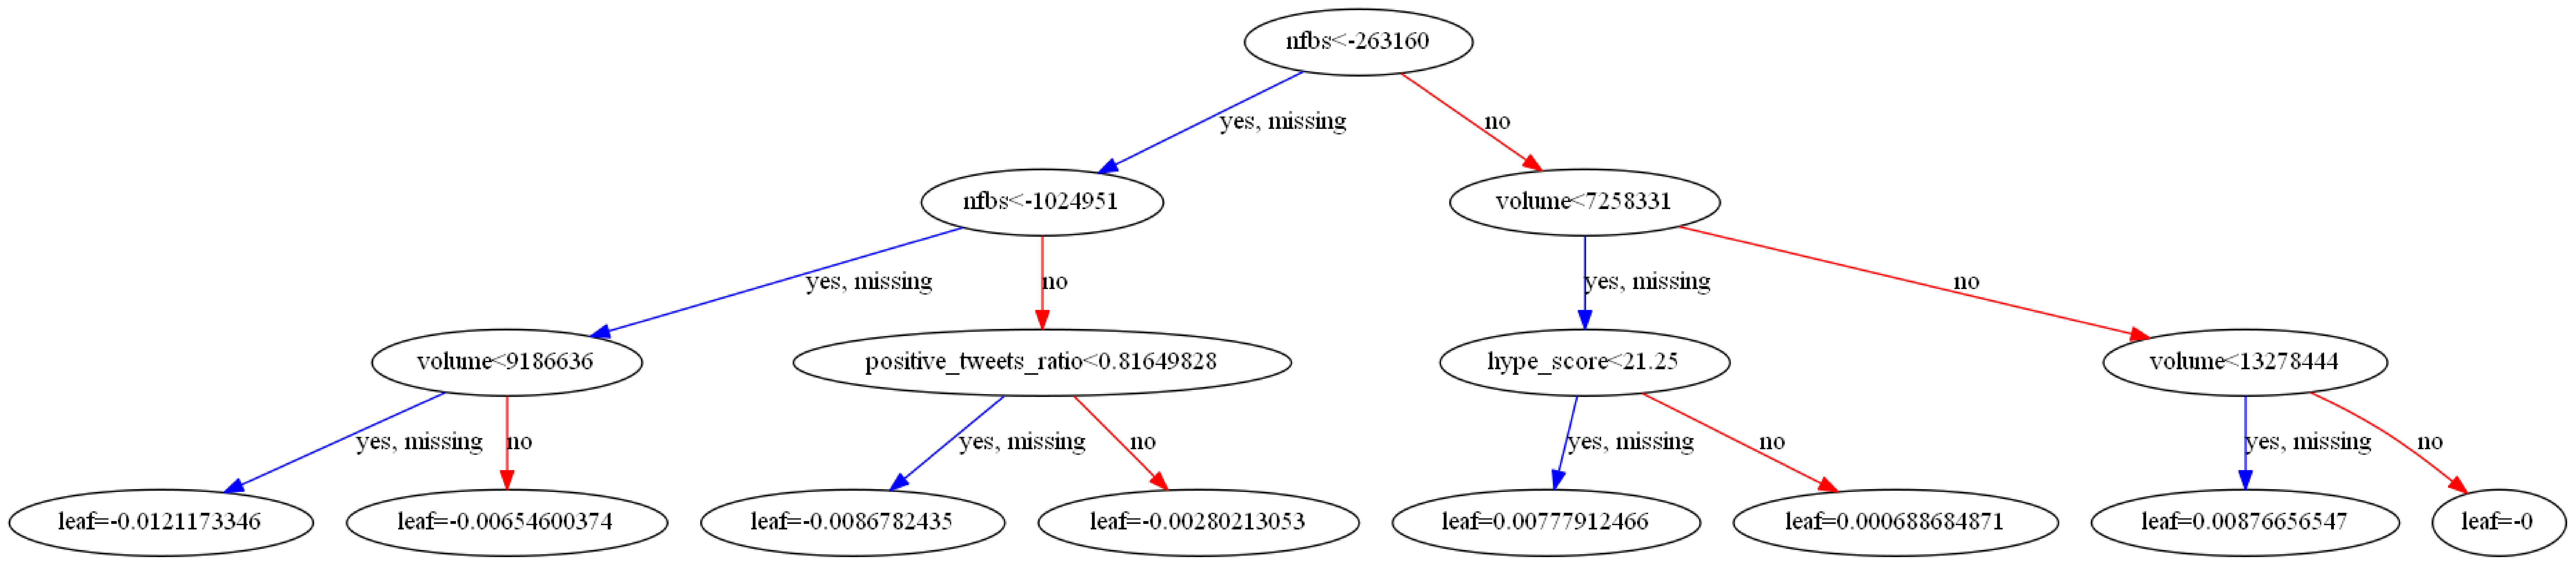

In [52]:
import matplotlib
xgboost.plot_tree(model, num_trees=2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 150)
fig.savefig('tree.png')

In [53]:
main_df.describe()

,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
count,1757.000000,1757.000000,1757.000000,1757.000000,1.757000e+03,1.757000e+03,1756.000000,1756.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000
mean,7305.215948,7342.247291,7261.730672,7304.290046,2.113681e+07,1.707499e+06,7303.870478,0.000186,52.385316,47.417188,0.896684,63.059476,79.649118,0.527604
std,709.074649,709.023182,705.252938,708.604712,4.172282e+08,6.137613e+07,709.336252,0.010371,38.824089,35.405455,0.121252,62.902461,80.098762,0.499380
min,5353.710000,5372.680000,5353.470000,5353.470000,6.339340e+05,-2.818710e+07,5353.470000,-0.069885,0.000000,0.000000,0.000000,-5.500000,0.000000,0.000000
25%,6846.550000,6874.630000,6803.390000,6843.830000,5.880245e+06,-5.565070e+05,6843.410000,-0.005576,27.000000,25.000000,0.870968,26.000000,33.500000,0.000000
50%,7358.530000,7390.000000,7320.640000,7357.280000,7.201591e+06,-1.052680e+05,7357.000000,0.000564,47.000000,43.000000,0.916667,48.000000,61.000000,1.000000
75%,7848.450000,7879.660000,7804.980000,7845.490000,8.919241e+06,3.479980e+05,7845.752500,0.006140,70.000000,64.000000,0.958333,83.000000,103.000000,1.000000
max,9051.750000,9078.370000,9008.410000,9058.620000,1.596931e+10,2.528117e+09,9058.620000,0.055419,450.000000,428.000000,1.000000,928.500000,1094.500000,1.000000


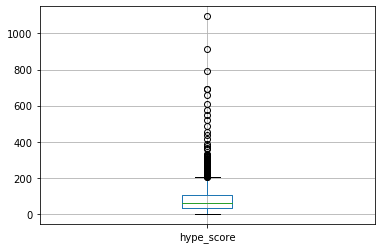

In [54]:
main_df.boxplot(column=[features[5]])

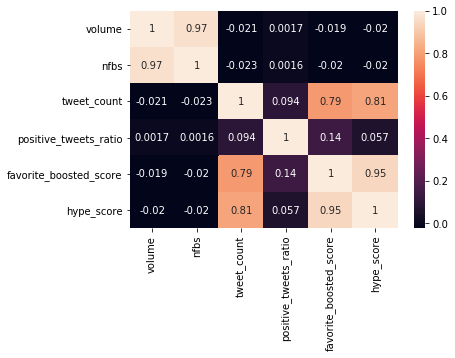

In [55]:
sns.heatmap(main_df[features].corr(), annot=True)

In [56]:
from eli5 import show_weights, show_prediction
show_weights(model)

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


Weight,Feature
0.4878,nfbs
0.1495,favorite_boosted_score
0.1311,hype_score
0.1099,volume
0.0637,positive_tweets_ratio
0.0579,tweet_count


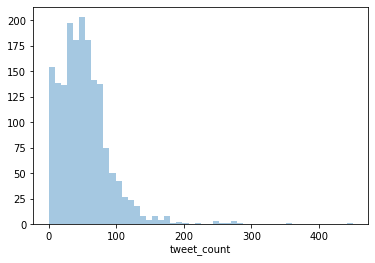

In [57]:
sns.distplot(main_df['tweet_count'], kde=False)

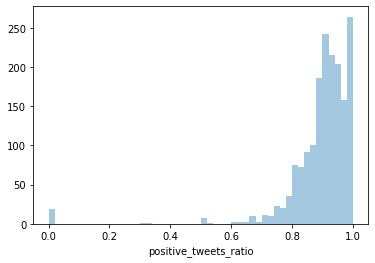

In [58]:
sns.distplot(main_df['positive_tweets_ratio'], kde=False)

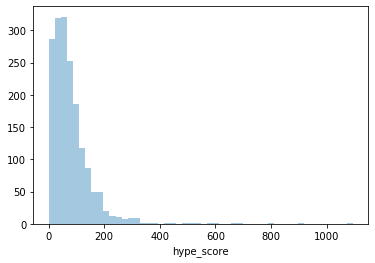

In [59]:
sns.distplot(main_df['hype_score'], kde=False)

,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
count,504.000000,504.000000,504.000000,504.000000,5.040000e+02,5.040000e+02,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,7817.323929,7853.311270,7768.533353,7811.861607,7.243097e+06,-4.390122e+04,7812.274147,-0.000057,56.855159,51.625000,0.912665,70.121032,87.130952,0.505952
std,498.937211,499.927199,499.503798,502.162808,4.447778e+06,1.819934e+06,501.739173,0.009485,31.203317,28.150834,0.069066,45.780098,55.590591,0.500461
min,6545.530000,6563.670000,6499.000000,6563.670000,8.615390e+05,-5.997956e+06,6563.670000,-0.026322,2.000000,1.000000,0.500000,-1.500000,3.500000,0.000000
25%,7498.952500,7546.655000,7460.560000,7501.435000,5.720503e+06,-5.766232e+05,7501.435000,-0.005610,33.000000,29.750000,0.876053,36.000000,47.875000,0.000000
50%,7847.435000,7868.040000,7798.915000,7837.295000,7.036422e+06,-1.599610e+05,7837.295000,0.000116,55.000000,50.000000,0.920958,63.250000,81.500000,1.000000
75%,8097.350000,8119.942500,8046.830000,8088.457500,8.360658e+06,2.674280e+05,8088.457500,0.005688,77.000000,70.000000,0.960196,94.125000,113.875000,1.000000
max,9051.750000,9078.370000,9008.410000,9058.620000,7.373306e+07,3.168495e+07,9058.620000,0.028528,169.000000,149.000000,1.000000,294.500000,367.000000,1.000000


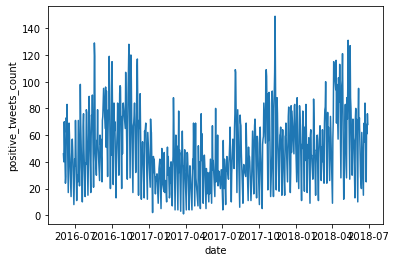

In [60]:
main_df.head()
main_df['date'] = pd.to_datetime(main_df['date'])
try_df = main_df[(main_df['date'] >= '2016-06-01') & (main_df['date'] <= '2018-06-30')]
sns.lineplot(try_df['date'], try_df['positive_tweets_count'])
try_df.describe()

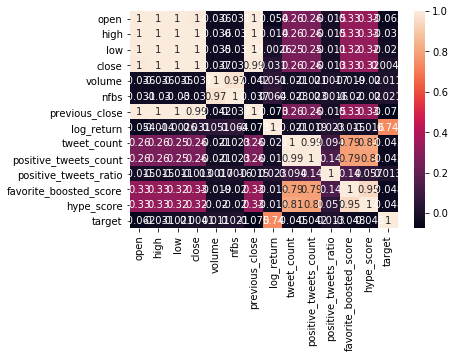

In [61]:
sns.heatmap(main_df.corr(), annot=True)

In [62]:
tweets_df

,symbol,epoch_time,name,handle,url,tweet,reply_count,retweet_count,favorite_count,date,sentiment_score,label,boosted_score
0,AC,1192399907,D,davvyk,https://twitter.com/davvyk/status/335801692,hope england flatten the $ac)sts in RWC,0,0,0.0,10/15/2007,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",1,1.0
1,AC,1218207877,JKIngram84,JKIngram154,https://twitter.com/JKIngram154/status/881583626,I´ve been fighting with banks for the last 12 ...,0,0,0.0,08/09/2008,"{'neg': 0.095, 'neu': 0.53, 'pos': 0.375, 'com...",1,1.0
2,AC,1261780693,"DIRECTED BY\r\nAC,🎥",mikemikefilms,https://twitter.com/mikemikefilms/status/70438...,& we STILL gotta hit up $ac!.. Hmm I wonder if...,0,0,0.0,12/26/2009,"{'neg': 0.136, 'neu': 0.767, 'pos': 0.098, 'co...",-1,-1.0
3,AC,1261298199,BABY D,DEONNAROCKSTARR,https://twitter.com/DEONNAROCKSTARR/status/685...,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,0,0,0.0,12/20/2009,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",1,1.0
13,AC,1259889821,JENNIFER WILLIAM$,scarygirl916,https://twitter.com/scarygirl916/status/632215...,@fionuhh so I thot I was gonna die cuz therezz...,0,0,0.0,12/04/2009,"{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...",-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206243,URC,1505790466,MyTradePH-Abacus Sec,MyTradePH,https://twitter.com/MyTradePH/status/909977286...,"... $URC, $SMC, $BEL. Read the full report at ...",0,0,0.0,09/19/2017,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0
206244,URC,1505737174,kentir,ko_kom101,https://twitter.com/ko_kom101/status/909753762...,"coindera: Top 3\r\nURC,\r\nURC, $URC $BTC on Y...",0,0,1.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,1.5
206245,URC,1505736062,Shitcoin Calls,ShitcoinCalls,https://twitter.com/ShitcoinCalls/status/90974...,"New post in Shitcoin Calls: Top 3\r\nURC, $URC...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,2.0
206246,URC,1505736031,Coindera,coindera,https://twitter.com/coindera/status/9097489714...,"Top 3\r\nURC,\r\nURC, $URC $BTC on @YobitExcha...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",1,2.0


In [63]:
import re

def generate_ngrams(s, n):
    # Convert to lowercases
    s = s.lower()
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in set(ngrams)]

In [64]:
import re
illegal_strings = 'Media General|Alamos Gold|Mobile Telesystems|Manitoba Telecom Services|Mobil\'nye|TeleSistemy|Russia|SM Energy|SMEnergy|Praxair|Pelangio|Michael Page International|Maurel et Prom|FibroGen|Direxion Emerging Markets|Direxion|Emerging Market|Claim Free|Accor|French|Bridgepoint Education|Zovio|Belmond|ASX|DTG'
tweets_df = tweets_df[~tweets_df['tweet'].str.contains(illegal_strings, flags=re.I, na=False)]
tweets_df

,symbol,epoch_time,name,handle,url,tweet,reply_count,retweet_count,favorite_count,date,sentiment_score,label,boosted_score
0,AC,1192399907,D,davvyk,https://twitter.com/davvyk/status/335801692,hope england flatten the $ac)sts in RWC,0,0,0.0,10/15/2007,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",1,1.0
1,AC,1218207877,JKIngram84,JKIngram154,https://twitter.com/JKIngram154/status/881583626,I´ve been fighting with banks for the last 12 ...,0,0,0.0,08/09/2008,"{'neg': 0.095, 'neu': 0.53, 'pos': 0.375, 'com...",1,1.0
2,AC,1261780693,"DIRECTED BY\r\nAC,🎥",mikemikefilms,https://twitter.com/mikemikefilms/status/70438...,& we STILL gotta hit up $ac!.. Hmm I wonder if...,0,0,0.0,12/26/2009,"{'neg': 0.136, 'neu': 0.767, 'pos': 0.098, 'co...",-1,-1.0
3,AC,1261298199,BABY D,DEONNAROCKSTARR,https://twitter.com/DEONNAROCKSTARR/status/685...,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,0,0,0.0,12/20/2009,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",1,1.0
13,AC,1259889821,JENNIFER WILLIAM$,scarygirl916,https://twitter.com/scarygirl916/status/632215...,@fionuhh so I thot I was gonna die cuz therezz...,0,0,0.0,12/04/2009,"{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...",-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206243,URC,1505790466,MyTradePH-Abacus Sec,MyTradePH,https://twitter.com/MyTradePH/status/909977286...,"... $URC, $SMC, $BEL. Read the full report at ...",0,0,0.0,09/19/2017,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0
206244,URC,1505737174,kentir,ko_kom101,https://twitter.com/ko_kom101/status/909753762...,"coindera: Top 3\r\nURC,\r\nURC, $URC $BTC on Y...",0,0,1.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,1.5
206245,URC,1505736062,Shitcoin Calls,ShitcoinCalls,https://twitter.com/ShitcoinCalls/status/90974...,"New post in Shitcoin Calls: Top 3\r\nURC, $URC...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,2.0
206246,URC,1505736031,Coindera,coindera,https://twitter.com/coindera/status/9097489714...,"Top 3\r\nURC,\r\nURC, $URC $BTC on @YobitExcha...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",1,2.0


In [65]:
tweets_df.query('symbol == "SM"').to_csv('hehe.csv')

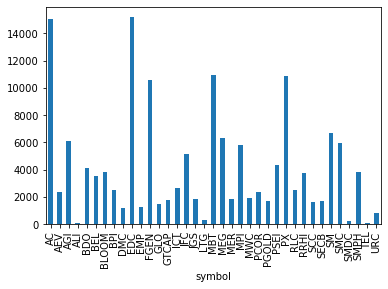

In [66]:
tweets_df.groupby(['symbol']).count()['date'].plot(kind='bar')

In [67]:
tweets_df['ngrams'] = tweets_df['tweet'].apply(lambda s: generate_ngrams(str(s).replace('\r', '').replace('\n', ''), n=3))
# tweets_df[['tweet', 'ngrams']].to_csv('hehe.csv')
tweets_df['ngrams']

0         [flatten the ac, england flatten the, sts in r...
1         [for the last, ra u d, been fighting with, d t...
2         [my plate to, still gotta hit, ac hmm i, gotta...
3         [ten 2 little, little bit more, li ten 2, mu i...
13        [homelessz in w, i was gonna, thot i was, i th...
                                ...                        
206243    [at http mytrade, the full report, read the fu...
206244    [top 3urc urc, urc deth btc, on yobitexchange ...
206245    [top 3urc urc, urc deth btc, post in shitcoin,...
206246    [top 3urc urc, urc deth btc, on yobitexchange ...
206247    [hb 5636 tel, s short takes, tax reform hb, 56...
Name: ngrams, Length: 152726, dtype: object

In [68]:
tweets_df.query('symbol == "SECB"')

,symbol,epoch_time,name,handle,url,tweet,reply_count,retweet_count,favorite_count,date,sentiment_score,label,boosted_score,ngrams
178924,SECB,1576632634,BPI Trade,BPItrade,https://twitter.com/BPItrade/status/1207110876...,$SECB raises Php2.3B from 5.5-yr LTNCDs.,0,0,0.0,12/18/2019,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0,"[raises php2 3b, 5 5 yr, php2 3b from, 3b from..."
178925,SECB,1576626910,2TradeAsia,2TradeAsia,https://twitter.com/2TradeAsia/status/12070868...,$SECB issued P2bn LTNCDs. SECB successfully r...,0,0,1.0,12/18/2019,"{'neg': 0.0, 'neu': 0.771, 'pos': 0.229, 'comp...",1,1.5,"[ltncds from its, secb issued p2bn, will matur..."
178926,SECB,1576116608,Lexter Azurin,LFLAzurin,https://twitter.com/LFLAzurin/status/120494650...,"YTD index winners and losers\r\nSECB,Top loser...",1,18,28.0,12/12/2019,"{'neg': 0.151, 'neu': 0.711, 'pos': 0.138, 'co...",-1,-15.0,"[jfc 29 secb, secb mer 15, secb secb top, top ..."
178927,SECB,1574847822,Oneminuterunner,Oneminuterunner,https://twitter.com/Oneminuterunner/status/119...,"$SECB 204 on average volume.\r\nSECB,\r\nSECB,...",0,0,0.0,11/27/2019,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0,"[secb secb approaching, approaching r1 206, se..."
178928,SECB,1574405410,AMOS,aespolon,https://twitter.com/aespolon/status/1197769220...,"Ok lang walang matrade basta may $WLCON, $SLI,...",0,1,3.0,11/22/2019,"{'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'comp...",1,2.5,"[basta may wlcon, and secb to, may wlcon sli, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180614,SECB,1347244388,Charles Lim,duexcharles,https://twitter.com/duexcharles/status/2449868...,$SECB why you no let me ride,0,0,0.0,09/10/2012,"{'neg': 0.268, 'neu': 0.732, 'pos': 0.0, 'comp...",-1,-1.0,"[why you no, secb why you, let me ride, no let..."
180615,SECB,1347244067,dlftrades,dlftrades,https://twitter.com/dlftrades/status/244985493...,let's go $SECB,0,0,0.0,09/10/2012,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0,"[s go secb, let s go]"
180616,SECB,1346293036,Charles Lim,duexcharles,https://twitter.com/duexcharles/status/2409965...,dear $SECB mag pa ride ka please :(,0,0,0.0,08/30/2012,"{'neg': 0.227, 'neu': 0.391, 'pos': 0.383, 'co...",1,1.0,"[dear secb mag, ride ka please, pa ride ka, ma..."
180617,SECB,1346283233,Charles Lim,duexcharles,https://twitter.com/duexcharles/status/2409554...,$SECB 141 - 144,0,0,0.0,08/30/2012,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0,[secb 141 144]


In [69]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

In [70]:
import re
illegal_strings = 'Media General|Alamos Gold|Mobile Telesystems|Manitoba Telecom Services|Mobil\'nye|TeleSistemy|Russia|SM Energy|SMEnergy|Praxair|Pelangio|Michael Page International|Maurel et Prom|FibroGen|Direxion Emerging Markets|Direxion|Emerging Market|Claim Free|Accor|French|Bridgepoint Education|Zovio|Belmond|ASX|DTG'
tweets_df = tweets_df[~tweets_df['tweet'].str.contains(illegal_strings, flags=re.I, na=False)]
tweets_df

,symbol,epoch_time,name,handle,url,tweet,reply_count,retweet_count,favorite_count,date,sentiment_score,label,boosted_score,ngrams
0,AC,1192399907,D,davvyk,https://twitter.com/davvyk/status/335801692,hope england flatten the $ac)sts in RWC,0,0,0.0,10/15/2007,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",1,1.0,"[flatten the ac, england flatten the, sts in r..."
1,AC,1218207877,JKIngram84,JKIngram154,https://twitter.com/JKIngram154/status/881583626,I´ve been fighting with banks for the last 12 ...,0,0,0.0,08/09/2008,"{'neg': 0.095, 'neu': 0.53, 'pos': 0.375, 'com...",1,1.0,"[for the last, ra u d, been fighting with, d t..."
2,AC,1261780693,"DIRECTED BY\r\nAC,🎥",mikemikefilms,https://twitter.com/mikemikefilms/status/70438...,& we STILL gotta hit up $ac!.. Hmm I wonder if...,0,0,0.0,12/26/2009,"{'neg': 0.136, 'neu': 0.767, 'pos': 0.098, 'co...",-1,-1.0,"[my plate to, still gotta hit, ac hmm i, gotta..."
3,AC,1261298199,BABY D,DEONNAROCKSTARR,https://twitter.com/DEONNAROCKSTARR/status/685...,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,0,0,0.0,12/20/2009,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",1,1.0,"[ten 2 little, little bit more, li ten 2, mu i..."
13,AC,1259889821,JENNIFER WILLIAM$,scarygirl916,https://twitter.com/scarygirl916/status/632215...,@fionuhh so I thot I was gonna die cuz therezz...,0,0,0.0,12/04/2009,"{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...",-1,-1.0,"[homelessz in w, i was gonna, thot i was, i th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206243,URC,1505790466,MyTradePH-Abacus Sec,MyTradePH,https://twitter.com/MyTradePH/status/909977286...,"... $URC, $SMC, $BEL. Read the full report at ...",0,0,0.0,09/19/2017,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0,"[at http mytrade, the full report, read the fu..."
206244,URC,1505737174,kentir,ko_kom101,https://twitter.com/ko_kom101/status/909753762...,"coindera: Top 3\r\nURC,\r\nURC, $URC $BTC on Y...",0,0,1.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,1.5,"[top 3urc urc, urc deth btc, on yobitexchange ..."
206245,URC,1505736062,Shitcoin Calls,ShitcoinCalls,https://twitter.com/ShitcoinCalls/status/90974...,"New post in Shitcoin Calls: Top 3\r\nURC, $URC...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,2.0,"[top 3urc urc, urc deth btc, post in shitcoin,..."
206246,URC,1505736031,Coindera,coindera,https://twitter.com/coindera/status/9097489714...,"Top 3\r\nURC,\r\nURC, $URC $BTC on @YobitExcha...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",1,2.0,"[top 3urc urc, urc deth btc, on yobitexchange ..."


There are 19412908 words in the combination of all review.


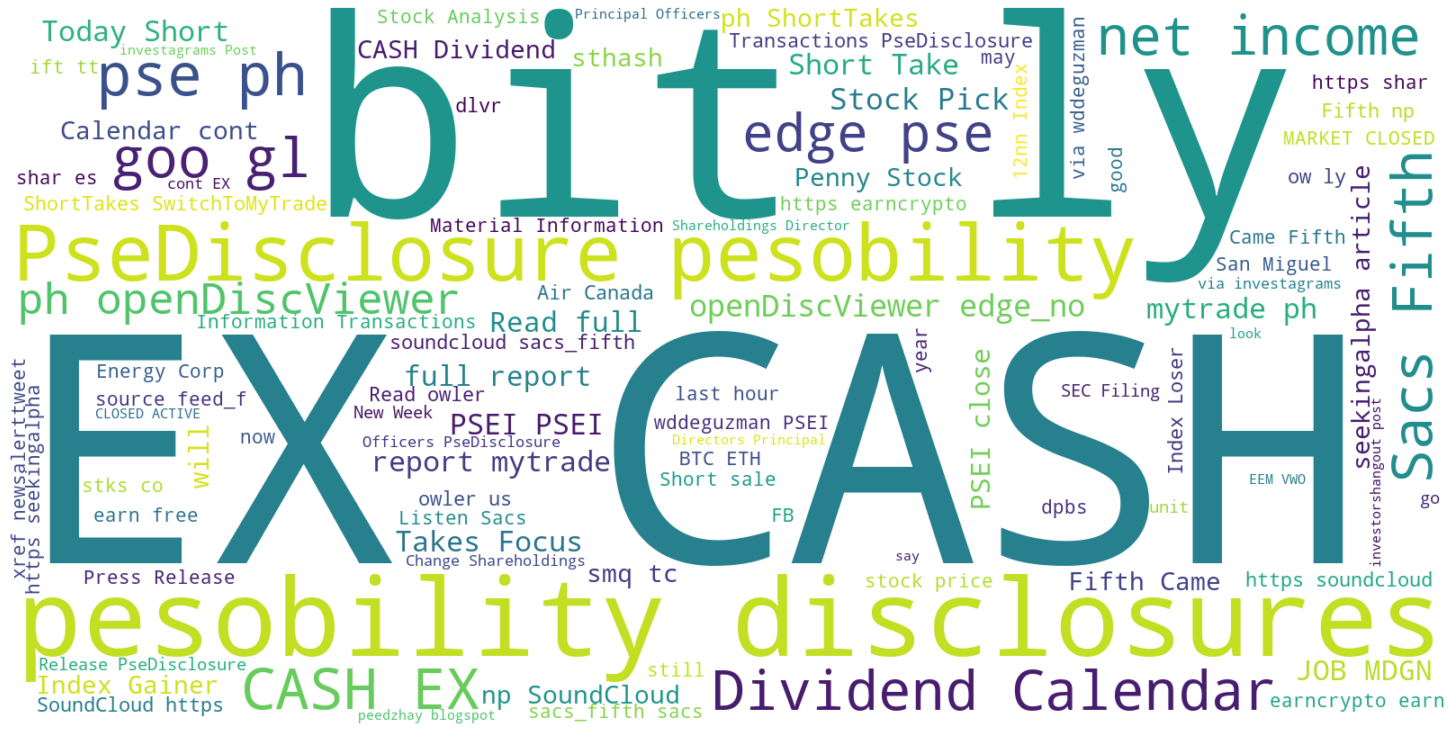

In [71]:
# Start with one review:
# text = tweets_df.tweet[0]
text = " ".join(str(review) for review in tweets_df.tweet)
print ("There are {} words in the combination of all review.".format(len(text)))

stopwords = set(STOPWORDS)
stopwords.update(["AC", "MER", "SECB", "MBT", "RRHI", "SCC", "SMPH", "URC", "AEV", "AGI", "ALI", "BDO", "BLOOM", "BPI",
                  "DMC", "FGEN", "GLO", "GTCAP", "ICT", "JFC", "JGS", "LTG", "MEG", "PGOLD", "SMC", "MPI", "RLC", "SM",
                  "PCOR", "EDC", "EMP", "PX", "BEL", "MWC"])
# # Create and generate a word cloud image:
wordcloud = WordCloud(max_words=100, background_color="white", stopwords=stopwords, width=1600, height=800).generate(text)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('wordcloud.png', bbox_inches='tight')

In [72]:
tweets_df.handle.value_counts().head(50)

PesobilityPse      5891
firstmetrosec      3855
wddeguzman         3598
wiz_redsuns        2969
MyTradePH          2804
UTradePH           2349
2TradeAsia         2119
BPItrade           1846
wealthsec          1826
PeeDzhay           1690
duexcharles        1601
ANCALERTS          1390
SeekingAlpha       1338
Only1SacsFifth     1338
tweetretweet        969
Stockaholics        918
DailyStockPlays     888
colfinancial        862
TraderTactics       847
semodough           808
SwingTradeBot       804
BargainTrapper      743
p2ptradeonline      735
JohnYu915           732
shortvolumes        689
IHPosts             686
rosnerstocks        682
J0eyV               665
PolgarStocks        658
IHPosts2            618
danrocks4           607
HutshotStocks       606
SpyfratsCall        603
moneyandstocks      601
joo20429            598
_kmontealegre       589
TheTraderDog        580
IHNewsDesk          575
Jake132013          556
JeromeCMorales      538
kingdelrosario      535
HDISecurities   

In [73]:
tweets_df.groupby('handle')['favorite_count'].sum().sort_values(ascending=False).head(50)

handle
JohnYu915          11767.0
wealthsec           7069.0
ANCALERTS           5849.0
semodough           5087.0
SpyfratsCall        4516.0
firstmetrosec       3898.0
wddeguzman          3815.0
colfinancial        3171.0
HoR_102             2789.0
salinaro17          2492.0
BPItrade            2236.0
2TradeAsia          2166.0
duexcharles         2126.0
KyberSwap           1545.0
Biomaven            1505.0
Pharmdca            1317.0
stakecube           1271.0
UTradePH            1109.0
LFLAzurin           1090.0
MyTradePH           1084.0
tradeyourplan        977.0
BrandonVanZee        941.0
ali                  871.0
cnnphilippines       809.0
gmanews              807.0
TraderTactics        771.0
firstcoinclub7       753.0
IrishGirlCrypt1      715.0
iamichimoku          712.0
ClaireJiao           696.0
notsofast            677.0
SeekingAlpha         638.0
StockRockNRoll       630.0
investagrams         610.0
khaldoggo69m         609.0
Super1NYC            597.0
tsizzle84            